# MODEL OUTLINE

__Step 1:__ Import Required Libraries

__Step 2:__ Data Extraction 

__Step 3:__ Graphical visualization

__Step 4:__ Data Preprocessing

__Step 5:__ Build LSTM Model

__Step 6:__ Train LSTM Model

__Step 7:__ Visualize Model Performance

__Step 8:__ Make Predictions and Inverse Transformations

# 1 -  IMPORT REQUIRED LIBRARIES



In [83]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2 
from statsmodels.tsa.seasonal import seasonal_decompose


# 2 - DATA EXTRACTION


In [84]:
stock_symbol = 'NIO'
start_date = '2018-01-01'
end_date = '2022-12-31'

# Download historical data
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Step 2: Data Preparation

# Calculate Exponential Moving Averages

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-12,6.00,6.93,5.35,6.60,6.60,66849000
2018-09-13,6.62,12.69,6.52,11.60,11.60,158346500
2018-09-14,12.66,13.80,9.22,9.90,9.90,172473600
2018-09-17,9.61,9.75,8.50,8.50,8.50,56323900
2018-09-18,8.73,9.10,7.67,7.68,7.68,41827600


# 3 - GRAPHICAL VISUALIZATION

In [85]:
import plotly.graph_objects as go

# Convert the DataFrame to have columns required for candlestick chart
data_candlestick = data.reset_index()

# Calculate Exponential Moving Averages
data['EMA_14'] = data['Close'].ewm(span=14, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()

fig = go.Figure(data=[go.Candlestick(x=data_candlestick['Date'],
                open=data_candlestick['Open'],
                high=data_candlestick['High'],
                low=data_candlestick['Low'],
                close=data_candlestick['Close'],
                increasing_line_color='green',
                decreasing_line_color='red',
                name='Candlestick')])

# Add EMA lines
fig.add_trace(go.Scatter(x=data.index, y=data['EMA_14'], mode='lines', name='EMA 14'))
fig.add_trace(go.Scatter(x=data.index, y=data['EMA_50'], mode='lines', name='EMA 50'))
fig.add_trace(go.Scatter(x=data.index, y=data['EMA_200'], mode='lines', name='EMA 200'))

fig.update_layout(title=f'Candlestick Chart with EMAs of Closing Prices of {stock_symbol} Over Time',
                  xaxis_title='Time',
                  yaxis_title='Price')

fig.show()

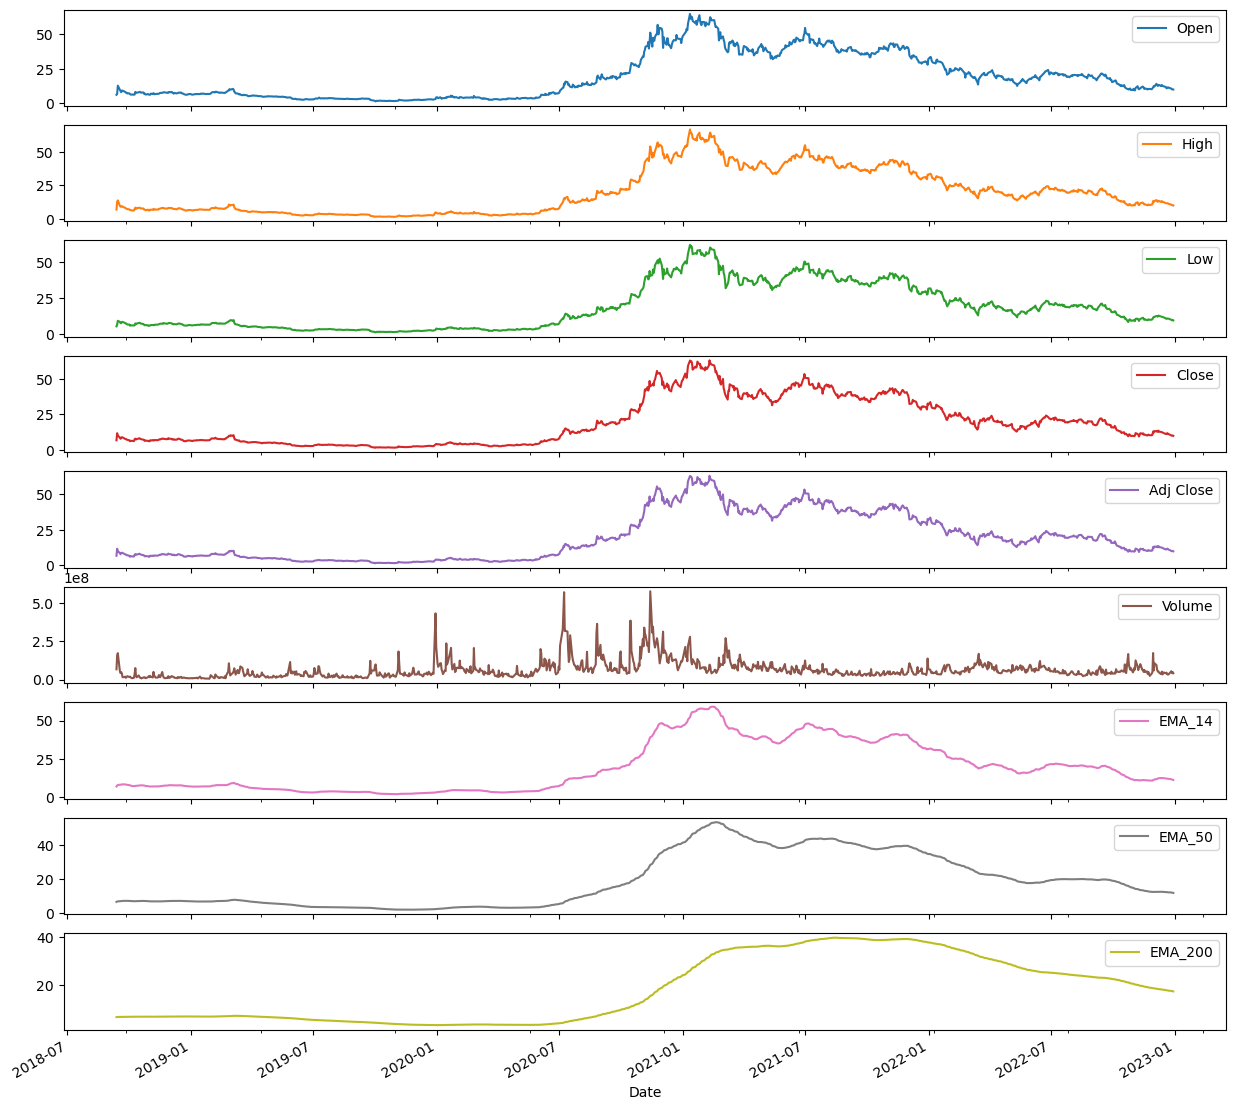

In [86]:
import matplotlib.pyplot as plt
data.plot(figsize=(15,15),subplots=True)

plt.show()

# 4 - DATA PREPROCESSING

In [87]:
# Choose target column and features
target_col = 'Close'
feature_cols = ['Open', 'High', 'Low', 'Volume']  # Example feature columns

# Split data into features and target variable
X = data[feature_cols].values
y = data[target_col].values


# Normalize the features and target using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Step 3: Create Sequences

sequence_length = 10
X_data = []
y_data = []
for i in range(len(y_scaled) - sequence_length):
    X_data.append(X_scaled[i:i+sequence_length])
    y_data.append(y_scaled[i+sequence_length])
X_data = np.array(X_data)
y_data = np.array(y_data)

# Split data into train and test sets


In [88]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)



print(y_train.shape)
print(X_train.shape)

(859, 1)
(859, 10, 4)


# MODEL LIBRARIES

In [89]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam


# 5 - BUILD LSTM MODEL

In [90]:
hyperparams = {
    'sequence_length': 10,
    'feature_cols': ['Open', 'High', 'Low', 'Volume'],
    'target_col': 'Close',
    'units': [128, 64, 64],
    'dropout_rate': 0.2,
    'l2_regularization': 0.001,
    'learning_rate': 0.001,
    'epochs': 40,
    'batch_size': 32,
    'validation_split': 0.2
    }

- **sequence_length:** This parameter determines the length of sequences used for training the LSTM model. It represents the number of time steps in each input sequence.

- **feature_cols:** This is a list of column names representing the features used as input for the model. These features are selected from the historical stock data.

- **target_col:** This parameter specifies the target column for prediction. It represents the column containing the variable you want the model to predict, in this case, the 'Close' price.

- **units:** This is a list of integers that defines the number of LSTM units in each LSTM layer. The model architecture consists of multiple LSTM layers, with the number of units specified in this list.

- **dropout_rate:** Dropout is a regularization technique to prevent overfitting. This parameter specifies the dropout rate for the dropout layers in the model.

- **l2_regularization:** L2 regularization adds a penalty term to the loss function, discouraging large weights in the model. This parameter determines the strength of the L2 regularization.

- **learning_rate:** The learning rate controls the step size during optimization. It influences how quickly the model adapts to the data. A lower learning rate can lead to slower but more stable convergence.

- **epochs:** The number of epochs represents how many times the entire dataset is passed through the model during training.

- **batch_size:** Batch size determines the number of samples that are used in each iteration of model training. A larger batch size can speed up training but may require more memory.

- **validation_split:** This parameter specifies the proportion of training data to be used for validation during training. It helps monitor the model's performance on unseen data.



In [91]:
model = Sequential()

for unit in hyperparams['units']:
    model.add(LSTM(units=unit, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hyperparams['dropout_rate']))

    
    
model.add(LSTM(units=hyperparams['units'][-1], activation='tanh', kernel_regularizer=l2(hyperparams['l2_regularization'])))
model.add(Dropout(hyperparams['dropout_rate']))
model.add(Dense(1))

optimizer = Adam(learning_rate=hyperparams['learning_rate'])
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 10, 128)           68096     
                                                                 
 dropout_19 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_20 (LSTM)              (None, 10, 64)            49408     
                                                                 
 dropout_20 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_21 (LSTM)              (None, 10, 64)            33024     
                                                                 
 dropout_21 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_22 (LSTM)              (None, 64)               

#  6 - TRAIN LSTM MODEL

In [92]:


# Train LSTM model
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
history = model.fit(X_train_reshaped, y_train, epochs=hyperparams['epochs'],
                    batch_size=hyperparams['batch_size'], validation_split=hyperparams['validation_split'], verbose=1)

Epoch 1/40
22/22 [==============================] - 8s 79ms/step - loss: 0.1165 - val_loss: 0.0946
Epoch 2/40
22/22 [==============================] - 0s 21ms/step - loss: 0.0644 - val_loss: 0.0619
Epoch 3/40
22/22 [==============================] - 0s 22ms/step - loss: 0.0432 - val_loss: 0.0362
Epoch 4/40
22/22 [==============================] - 0s 21ms/step - loss: 0.0313 - val_loss: 0.0284
Epoch 5/40
22/22 [==============================] - 0s 21ms/step - loss: 0.0231 - val_loss: 0.0189
Epoch 6/40
22/22 [==============================] - 0s 21ms/step - loss: 0.0185 - val_loss: 0.0150
Epoch 7/40
22/22 [==============================] - 0s 22ms/step - loss: 0.0151 - val_loss: 0.0156
Epoch 8/40
22/22 [==============================] - 0s 22ms/step - loss: 0.0121 - val_loss: 0.0107
Epoch 9/40
22/22 [==============================] - 0s 21ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 10/40
22/22 [==============================] - 0s 22ms/step - loss: 0.0104 - val_loss: 0.0136
Epoch 11/

# 7 - VISUALIZE MODEL PERFORMANCE

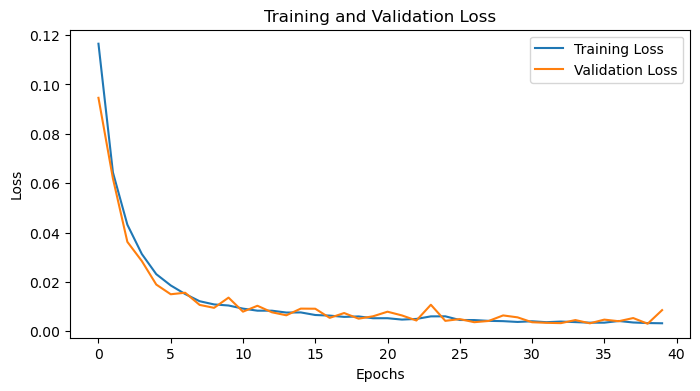

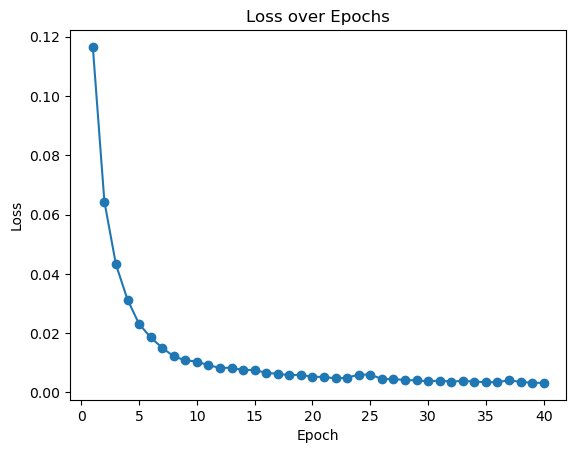

Epoch 1: Loss = 0.1165
Epoch 2: Loss = 0.0644
Epoch 3: Loss = 0.0432
Epoch 4: Loss = 0.0313
Epoch 5: Loss = 0.0231
Epoch 6: Loss = 0.0185
Epoch 7: Loss = 0.0151
Epoch 8: Loss = 0.0121
Epoch 9: Loss = 0.0108
Epoch 10: Loss = 0.0104
Epoch 11: Loss = 0.0091
Epoch 12: Loss = 0.0083
Epoch 13: Loss = 0.0083
Epoch 14: Loss = 0.0076
Epoch 15: Loss = 0.0076
Epoch 16: Loss = 0.0066
Epoch 17: Loss = 0.0063
Epoch 18: Loss = 0.0058
Epoch 19: Loss = 0.0060
Epoch 20: Loss = 0.0052
Epoch 21: Loss = 0.0053
Epoch 22: Loss = 0.0047
Epoch 23: Loss = 0.0050
Epoch 24: Loss = 0.0060
Epoch 25: Loss = 0.0060
Epoch 26: Loss = 0.0045
Epoch 27: Loss = 0.0045
Epoch 28: Loss = 0.0042
Epoch 29: Loss = 0.0041
Epoch 30: Loss = 0.0037
Epoch 31: Loss = 0.0040
Epoch 32: Loss = 0.0036
Epoch 33: Loss = 0.0039
Epoch 34: Loss = 0.0037
Epoch 35: Loss = 0.0034
Epoch 36: Loss = 0.0035
Epoch 37: Loss = 0.0041
Epoch 38: Loss = 0.0035
Epoch 39: Loss = 0.0033
Epoch 40: Loss = 0.0032


In [93]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Visualize loss values
loss_values = history.history['loss']

# Plot the loss values over epochs
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

# Print and visualize the loss values
for epoch, loss in enumerate(loss_values, 1):
    print(f"Epoch {epoch}: Loss = {loss:.4f}")

# 8 - MAKE PREDICTIONS AND INVERSE TRANSFORMATION

In [94]:

y_pred = model.predict(X_test)
y_pred_reshaped = y_pred.flatten()

predict_inv = scaler_y.inverse_transform(y_pred_reshaped.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test)

7/7 [==============================] - 1s 7ms/step


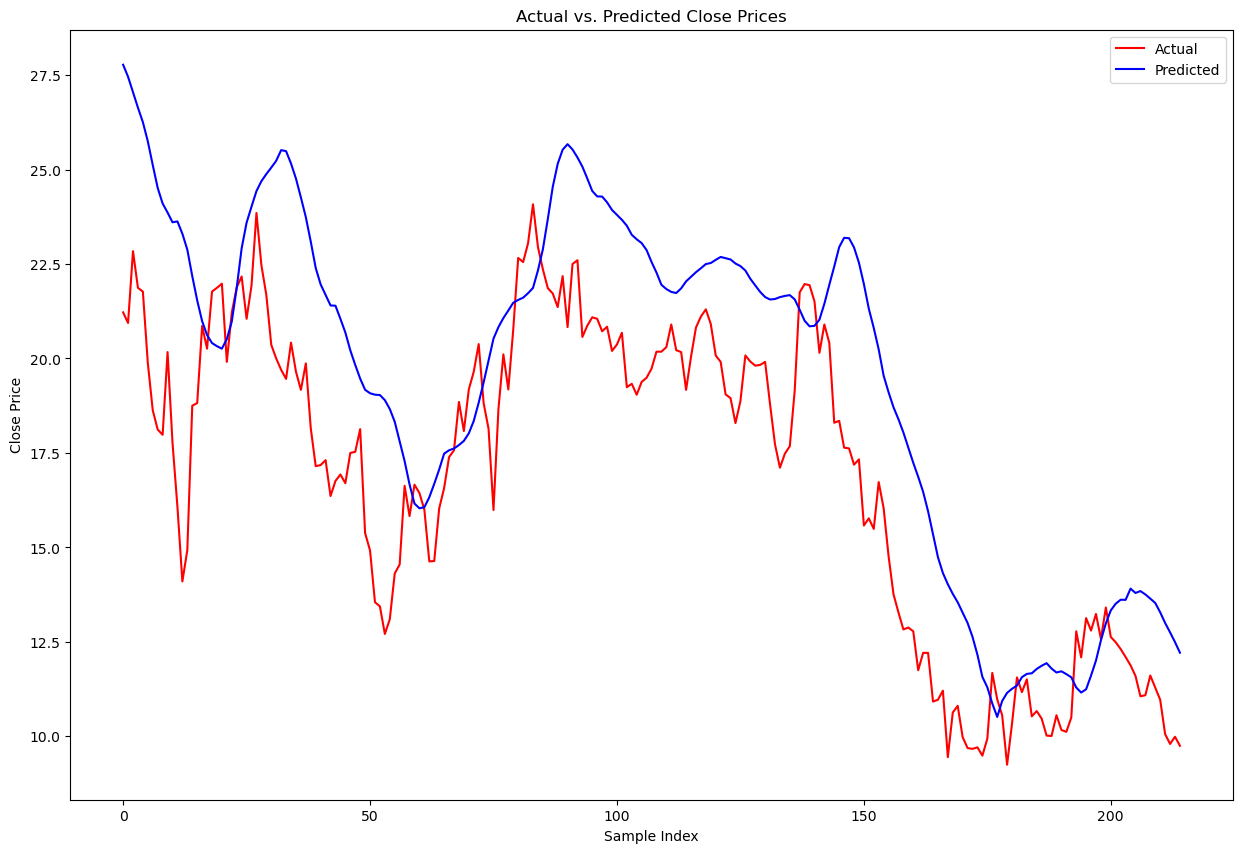

In [95]:

plt.figure(figsize=(15, 10))
plt.plot(y_test_inv, color='r', label='Actual')
plt.plot(predict_inv, color='b', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Prices')
plt.legend()
plt.show()

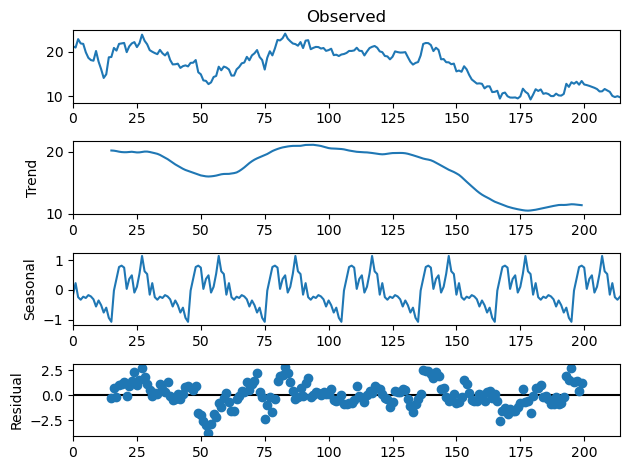

In [96]:
# Decompose the time series
decomposition = seasonal_decompose(y_test_inv, period=30)  # Adjust period as needed

# Plot decomposition
decomposition.plot()
plt.show()

Time-series decomposition is a technique that helps break down a time-series data into its **underlying components**, such as trend, seasonal, and residual. In the context of stock price prediction, time-series decomposition can provide insights into the different patterns and variations present in the data.

Here's how to interpret time-series decomposition:

1. **Components:** The decomposition process separates a time series into three main components:

   - **Trend:** The trend component represents the **long-term movement or direction** in the data. It helps identify whether the prices are generally increasing, decreasing, or remaining relatively stable over time.
   
   - **Seasonal:** The seasonal component captures **repeating patterns or fluctuations** that occur at fixed intervals, often due to external factors like seasons, holidays, or events. It helps identify cyclic behaviors that repeat regularly.
   
   - **Residual:** The residual component represents the **random noise or irregular variations** that are not accounted for by the trend and seasonal components. It includes all the unexpected or unpredictable variations.

2. **Plotting Decomposition:**

   The decomposition process typically involves plotting the original time series along with its decomposed components. This allows you to visually identify the individual contributions of each component to the overall time series.

3. **Interpreting the Components:**

   - If the **trend component** shows an increasing pattern, it indicates that the stock prices are generally rising over time. A decreasing trend suggests falling prices, while a flat trend implies stability.
   
   - The **seasonal component** helps identify recurring patterns that might be influenced by external factors. For example, if you observe regular spikes in certain months, it could be related to specific seasonal events.
   
   - The **residual component** reveals the random fluctuations that are not explained by the trend and seasonal patterns. Larger residuals might indicate periods of high volatility or unexpected market events.

Time-series decomposition is useful for understanding the underlying structure of your stock price data. It can help you identify trends, seasonal patterns, and unexpected variations that might impact your predictive models or trading strategies. By visualizing these components separately, you gain a more comprehensive view of how different factors contribute to the overall behavior of the stock prices.

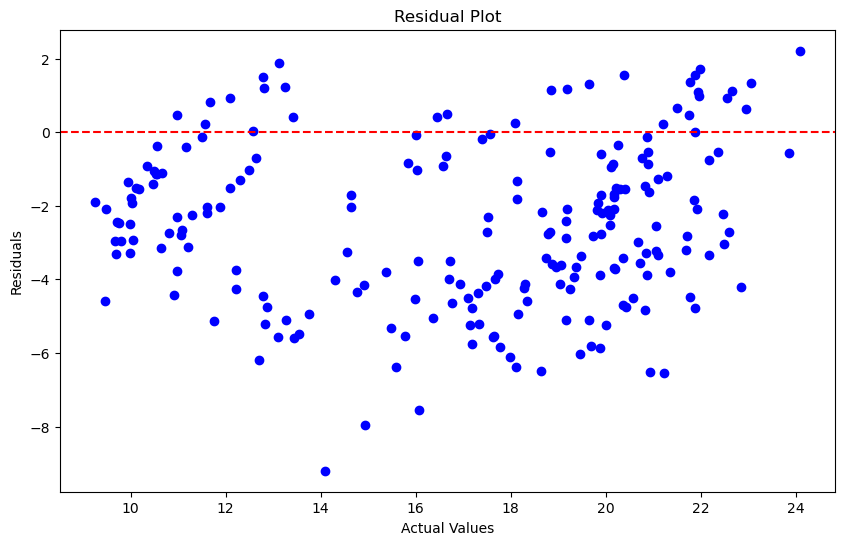

In [97]:
residuals = y_test_inv - predict_inv
plt.figure(figsize=(10, 6))
plt.scatter(y_test_inv, residuals, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

A residual plot is a graphical representation that helps you understand the distribution of errors or residuals in a predictive model. In the context of your stock price prediction, the residuals are the differences between the **actual closing prices** and the prices **predicted by model**.

Here's how to interpret a residual plot:

1. **Horizontal Line:** The residual plot usually includes a horizontal line at y = 0. This line represents the ideal scenario where the predicted values perfectly match the actual values. Points above the line indicate predictions that are too high, while points below the line indicate predictions that are too low.

2. **Scatter of Points:** Each point in the plot represents a specific prediction. The x-coordinate of the point corresponds to the actual value, while the y-coordinate represents the **residual for that prediction**.

3. **Patterns in Residuals:** Patterns or trends in the residuals indicate potential issues in your model. Here's how to interpret different types of patterns:

   - **Random Scatter:** If the residuals are randomly scattered around the y = 0 line, it suggests that your model is making relatively consistent predictions across different levels of the actual values. This is a good indication of a well-behaved model.
   
   - **U-Shaped Pattern:** If the residuals form a U-shaped pattern, it might indicate that your model is systematically **overestimating predictions for smaller values and underestimating for larger values**. This could be a sign of non-linearity that your model isn't capturing.
   
   - **Fan-Shaped Pattern:** A fan-shaped pattern suggests **increasing variability of residuals as the actual values increase or decrease**. This could mean that your model's predictions are more accurate for certain ranges of values than others.
   
   - **Funnel Pattern:** A funnel-shaped pattern might indicate **heteroscedasticity, where the variance of residuals changes with the magnitude of the actual values**. This can affect the reliability of predictions, especially if your model is more accurate for certain ranges of data.
   
4. **Outliers:** Outliers in the residual plot represent predictions where your model is significantly off the mark. These points are worth investigating, as they might provide insights into data quality issues or model shortcomings.

5. **Uniform Distribution:** If the residuals are uniformly distributed around the y = 0 line, it suggests that your model's predictions are unbiased but might lack precision.

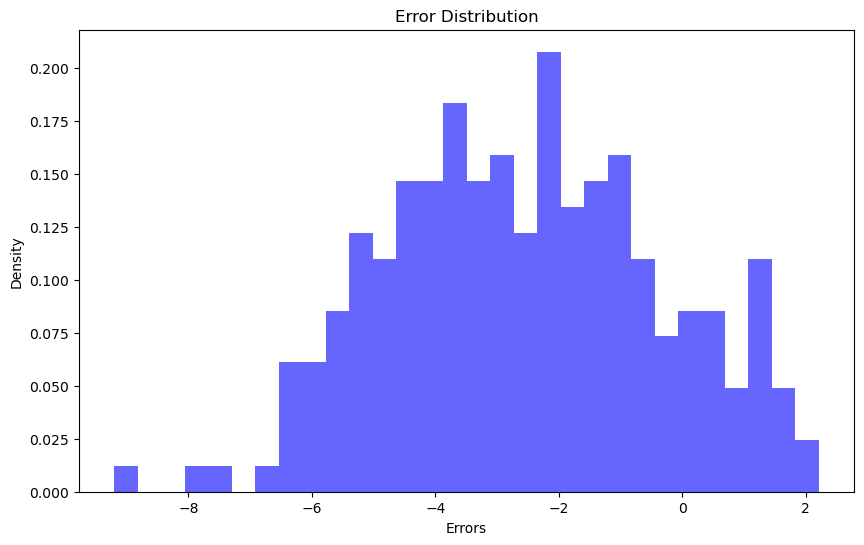

In [98]:
errors = y_test_inv - predict_inv
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, density=True, alpha=0.6, color='blue')
plt.xlabel('Errors')
plt.ylabel('Density')
plt.title('Error Distribution')
plt.show()

Error distribution is a concept that helps you understand the distribution of **errors or residuals** in a predictive model. In the context of your stock price prediction, errors are the differences between the **actual closing prices** and the prices **predicted by your model**.

Here's how to interpret error distribution:

1. **Histogram or Density Plot:** The error distribution is often visualized using a **histogram or kernel density estimate plot**. This plot shows the frequency or density of different error values.

2. **Centered around Zero:** In an ideal case, the error distribution should be centered around zero. This means that your model's predictions are, on average, unbiased and equally likely to be above or below the actual values.

3. **Symmetry:** A symmetric error distribution indicates that your model's predictions are equally likely to be above or below the actual values. This suggests that your model is not systematically biased.

4. **Skewness:** If the error distribution is skewed to the right (positively skewed), it means that your model tends to **underestimate** the prices more often than it overestimates them. Conversely, if it's skewed to the left (negatively skewed), your model tends to **overestimate** prices more often.

5. **Kurtosis:** Kurtosis measures the **tail heaviness** of the distribution. High kurtosis indicates heavy tails, meaning that your model's predictions occasionally have extreme errors.

6. **Outliers:** Outliers in the error distribution represent predictions where your model is significantly off the mark. These points are worth investigating, as they might provide insights into data quality issues or model shortcomings.

7. **Assumptions:** The error distribution provides insights into whether your model meets certain assumptions, such as **homoscedasticity** (constant variance of errors) and **normality** (errors follow a normal distribution).

Understanding the error distribution is important for assessing the reliability of your model's predictions. A centered and symmetric distribution indicates that your model is making unbiased predictions on average. Skewed or heavy-tailed distributions might suggest that your model needs further improvement or that certain data patterns are not captured effectively.